In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity.
What we will need:
- "imagenet_trained_model_weights.pkl"
- The betas and experiment stimuli
- A brain mask

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import theano
import theano.tensor as T

import src.numpy_utility as pnu
import src.fwrf as fwrf
from src.fwrf import fpX
from src.file_utility import save_stuff

/usr/local/lib/python2.7/dist-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


theano floatX: float32
numpy floatX: <type 'numpy.float32'>


Using cuDNN version 7605 on context None
Preallocating 3041/6083 Mb (0.500000) on cuda0
Mapped name None to device cuda0: GeForce GTX TITAN Z (0000:07:00.0)


In [3]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [4]:
subject = 2
saveext = ".png"
savearg = {'format':'png', 'dpi': 60, 'frameon': False}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())
model_name = 'deepnet-fwrf'

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
output_dir = root_dir+"output/S%02d/" % subject
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print ("Time Stamp: %s" % timestamp)

Time Stamp: Nov-13-2019_1708


# Load the stimuli images

In [5]:
nsd_root = "/home/styvesg/repo.local/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"

In [6]:
exp_design = loadmat(exp_design_file)

In [7]:
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)
print ordering.shape
print np.min(ordering), np.max(ordering)

(30000,)
0 9999


In [8]:
image_data_set = h5py.File(stim_root + "S%d_stimuli.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli'])
image_data_set.close()

print (image_data.shape)
print (image_data.dtype)
print (np.min(image_data[0]), np.max(image_data[0]))

(10000, 3, 227, 227)
uint8
(0, 255)


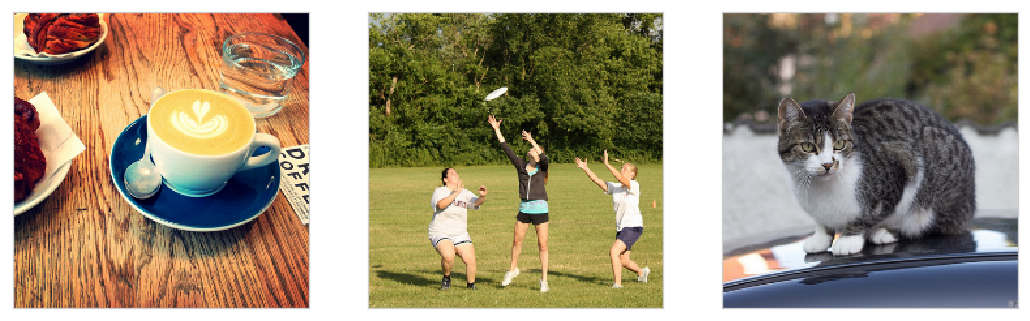

In [9]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [10]:
from src.file_utility import load_mask_from_nii, view_data

In [11]:
roi_map = {1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 5: 'V3v', 6: 'V3d', 7: 'hV4', 8: 'VO1', 9: 'VO2', \
           10: 'PHC1', 11: 'PHC2', 12: 'MST', 13: 'hMT', 14: 'LO2', 15: 'LO1', 16: 'V3b', 17: 'V3a', \
           18: 'IPS0', 19: 'IPS1', 20: 'IPS2', 21: 'IPS3', 22: 'IPS4', 23: 'IPS5', 24: 'SPL1', 25: 'FEF',\
           0: 'other'}

In [14]:
voxel_r2_full      = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz"%(subject,))
brain_mask_full    = load_mask_from_nii(nsd_root + "mask/subj%02d/subj%02d_mean_mask.nii.gz"%(subject,subject))
general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))
voxel_roi_full     = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))

brain_mask_full = brain_mask_full.flatten().astype(bool)
voxel_r2_brain  = voxel_r2_full.flatten()[brain_mask_full]
voxel_idx_brain = np.arange(len(brain_mask_full))[brain_mask_full]
voxel_roi_brain = voxel_roi_full.flatten()[brain_mask_full]

general_mask_full = (general_mask_full==1).flatten().astype(bool)
voxel_r2_general  = voxel_r2_full.flatten()[general_mask_full]
voxel_idx_general = np.arange(len(brain_mask_full))[general_mask_full]
voxel_roi_general = voxel_roi_full.flatten()[general_mask_full]

## Display a slice of the data

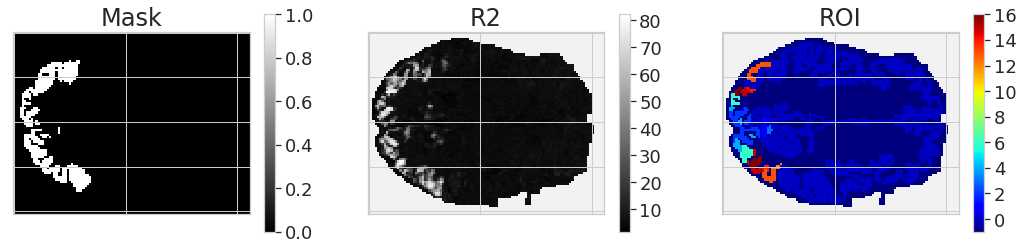

In [15]:
volume_r2         = view_data(voxel_r2_full.shape, voxel_idx_brain, np.nan_to_num(voxel_r2_brain))
volume_brain_mask = view_data(voxel_r2_full.shape, np.arange(len(brain_mask_full)), general_mask_full)
volume_brain_roi  = view_data(voxel_r2_full.shape, voxel_idx_brain, voxel_roi_brain)

slice_idx = 40
fig = plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,2)
plt.imshow(volume_r2[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('R2')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,3,3)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

In [ ]:
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

def load_betas(folder_name, zscore=False, voxel_mask=None, up_to=0):
    from src.file_utility import list_files
    matfiles = []
    betas = []
    k = 0
    for filename in list_files(folder_name):
        if ".mat" in filename:
            k += 1
            if up_to>0 and k>up_to:
                break
            matfiles += [filename,]
            print filename
            ##
            beta_data_set = h5py.File(filename, 'r')
            values = np.copy(beta_data_set['betas'])
            print values.shape
           
            if voxel_mask is None:
                betas += [values.reshape((len(values), -1), order='F').astype(np.float32) / 300.,]
            else:
                betas += [values.reshape((len(values), -1), order='F')[:,voxel_mask.flatten()].astype(np.float32) / 300.,]
            beta_data_set.close()
            if zscore: 
                mb = np.mean(betas[-1], axis=0, keepdims=True)
                sb = np.std(betas[-1], axis=0, keepdims=True)
                
                betas[-1] = np.nan_to_num((betas[-1] - mb) / (sb + 1e-6))
                print ("<beta> = %.3f, <sigma> = %.3f" % (np.mean(mb), np.mean(sb)))
    return np.concatenate(betas, axis=0), matfiles

voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=general_mask_full, up_to=0)
print voxel_data.shape

/home/styvesg/repo.local/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
(750, 84, 106, 82)
<beta> = 1.016, <sigma> = 1.010
/home/styvesg/repo.local/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
(750, 84, 106, 82)
<beta> = 0.936, <sigma> = 0.976
/home/styvesg/repo.local/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
(750, 84, 106, 82)
<beta> = 0.910, <sigma> = 0.966
/home/styvesg/repo.local/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
(750, 84, 106, 82)
<beta> = 1.098, <sigma> = 0.998
/home/styvesg/repo.local/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
(750, 84, 106, 82)
<beta> = 0.912, <sigma> = 0.965
/home/styvesg/repo.local/datasets/nsd/nsddata_betas/ppdata/subj02/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session06.mat
(

In [ ]:
voxel_idx = voxel_idx_general
voxel_roi = voxel_roi_general
voxel_r2  = voxel_r2_general

## Voxel grouping and voxel ROI iterator

In [ ]:
def iterate_roi(group, voxelroi, roimap):
    for g in group:
        g_name = ''
        mask = np.zeros(shape=voxelroi.shape, dtype=bool)
        for i,roi in enumerate(g):
            g_name += roimap[roi] + ('-' if i+1<len(g) else '')
            mask = np.logical_or(mask, voxelroi==roi)
        yield mask, g_name

roi_group = [[1,2],[3,4],[5,6], [7], [8,9], [10,11], [12], [13], [14,15], [16,17], [18,19,20,21,22,23], np.arange(1,24)]
for roi_mask, roi_name in iterate_roi(roi_group, voxel_roi, roi_map):
    print "%d \t: %s" % (np.sum(roi_mask), roi_name)

In [ ]:
coarse_group = [[1,2],[3,4],[5,6], [7,8,9,10,11,12,13], [14,15,16,17], [18,19,20,21,22,23]]
for roi_mask, roi_name in iterate_roi(coarse_group, voxel_roi, roi_map):
    print "%d \t: %s" % (np.sum(roi_mask), roi_name)

---

## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [ ]:
data_size, nv = voxel_data.shape 
print ("Total number of voxels = %d" % nv)

ordering_data = ordering[:data_size]
shared_mask   = ordering_data<1000  # the first 1000 indices are the shared indices

val_size = np.sum(shared_mask)
trn_size = data_size - val_size
print ("Validation size =", val_size, ", Training size =", trn_size)

- "stim_data" includes stimuli repeat. Takes more memory but it is easier to align with the single-trial voxel activity.

In [ ]:
## double and triple check that I haven't misaligned the image and responses.
trn_voxel_data = voxel_data[~shared_mask]
val_voxel_data = voxel_data[shared_mask]

stim_data = image_data[ordering_data] # reduce to only the samples available thus far

trn_stim_data = stim_data[~shared_mask]
val_stim_data = stim_data[shared_mask]

In [ ]:
plt.figure(figsize=(20,20))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(val_stim_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

---

---

# Shuffle voxels
- Since we loop over voxels. We don't want to hit organized clusters of similar voxels

In [21]:
nvv = val_voxel_data.shape[1]
voxel_order = np.arange(nvv)
#np.random.shuffle(voxel_order)

vpc_idx = voxel_idx[voxel_order]
vpc_roi = voxel_roi[voxel_order]
vpc_r2  = voxel_r2[voxel_order]
trn_vpc_data = trn_voxel_data[:,voxel_order]
val_vpc_data = val_voxel_data[:,voxel_order]

# Shuffle training samples
- In order to prevent batch overfitting to potential session recording bias (unlikely anyway since we've already z-scored per session)

In [22]:
# shuffle trn data
sample_order = np.arange(len(trn_stim_data))
np.random.shuffle(sample_order)
trn_stim_data = trn_stim_data[sample_order]
trn_vpc_data = trn_vpc_data[sample_order]

# Reference model
## Symbolic variables representing all the feature maps and the output of the DNN feature extractor.

In [23]:
from src.data_preparation import dnn_feature_extractor

_X = (T.TensorType('uint8', (False,)*4))()
_Y = T.ivector()

_fmaps, _Ybar, _params = dnn_feature_extractor(_X, param_file_name=net_dir + "imagenet_trained_model_weights.pkl")

Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7f04973ed290>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 96, 111, 111)
Params
        |-- W         : (96, 3, 7, 7)
        |-- b         : (96,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7f049740be10>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 256, 27, 27)
Params
        |-- W         : (256, 96, 5, 5)
        |-- b         : (256,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7f049741f1d0>
Name	: None
Type	: <class 'lasagne.layers.conv.Conv2DLayer'>
Shape	: (None, 384, 13, 13)
Params
        |-- W         : (384, 256, 3, 3)


Layer	: <lasagne.layers.normalization.BatchNormLayer object at 0x7f049740bf90>
Name	: None
Type	: <class 'lasagne.layers.normalization.BatchNormLayer'>
Shape	: (None, 384, 13, 13)
Params
        |-- mean      : (384,)
        |-- inv_std   : (384,)


Layer	: <lasagne.layers.conv.Conv2DLayer object at 0x7f0497777e90>
Name	:

In [24]:
print 'COMPILING'
t = time.time()
fmaps_fn = theano.function([_X], _fmaps)
print '%.2f seconds to compile theano functions'%(time.time()-t)

COMPILING
3.94 seconds to compile theano functions


In [25]:
print image_data.shape #[ordering_data]
print stim_data.shape
print len(shared_mask)
#[fm[~shared_mask] for fm in fmaps]

(10000, 3, 227, 227)
(30000, 3, 227, 227)
30000


## Perform subselection of feature maps
Performs a running variance calculation on the training set to determine which feature maps to use 'iif' a layer contains more than fmap_max feature maps. Otherwise, we keep all the feature maps for that layer. We also concatenate layers that have the same spatial resolution, and create a tuning mask that maps feature weights to the original network layer index.

In [26]:
from src.data_preparation import create_dnn_feature_maps
fmap_vars, layer_rlist, fmaps_sizes, fmaps_count, lmask, fmask = \
    create_dnn_feature_maps(trn_stim_data, fmaps_fn, batch_size=200, fmap_max=512, trn_size=trn_size) 
## convert range list (rlist) into binary masks over the joint features
tuning_masks = []
for rl in layer_rlist:
    tm = np.zeros(shape=(fmaps_count,), dtype=bool)
    tm[rl] = True
    tuning_masks += [tm,]
assert np.sum(sum(tuning_masks))==fmaps_count, "%d != %d" % (np.sum(sum(tuning_masks)), fmaps_count)

layer: 0, shape=(200, 96, 55, 55)
layer: 1, shape=(200, 256, 27, 27)
layer: 2, shape=(200, 384, 13, 13)
layer: 3, shape=(200, 384, 13, 13)
layer: 4, shape=(200, 256, 13, 13)
layer: 5, shape=(200, 512, 1, 1)
layer: 6, shape=(200, 512, 1, 1)
layer: 7, shape=(200, 512, 1, 1)

fmaps: 0, shape=(200, 96, 55, 55)
fmaps: 1, shape=(200, 256, 27, 27)
fmaps: 2, shape=(200, 1024, 13, 13)
fmaps: 3, shape=(200, 1536, 1, 1)


## Reduce the symbolic feature maps to those selected

In [27]:
_sfmaps = [T.concatenate([_fmaps[l] for l in lm], axis=1).take(fm,axis=1) for lm,fm in zip(lmask,fmask)]

## Create a grid of receptive field candidates

In [28]:
lx = ly = 1. # 1 stimuli per stimuli
nx = ny = 8
smin, smax = 0.05, 0.40
ns = 6

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
model_specs = [[(0., lx*1.1), (0., ly*1.1), (smin, smax)], [fwrf.linspace(nx), fwrf.linspace(ny), fwrf.logspace(ns)]]
# initial values of the fwrf model parameters
voxel_params_init = [fwrf.zeros_init,]

models = fwrf.model_space(model_specs)
print models.shape

(384, 3)


## Training

In [29]:
log_act_func = lambda x: np.log(1+np.abs(x))*np.tanh(np.abs(x)) #np.log(1+np.sqrt(np.abs(x)))
_log_act_func = lambda _x: T.log(fpX(1)+T.abs_(_x))*T.tanh(T.abs_(_x)) #T.log(fpX(1)+T.sqrt(T.abs_(_x)))
    
sample_batch_size = 200
voxel_batch_size = 500
model_batch_size = 32
model_minibatch_size = 8
holdout_size = 1000
lambdas = np.logspace(3.5,6.5,6)

best_scores, best_lambdas, best_w_params, best_rf_params, best_avg, best_std = \
    fwrf.batched_learn_params_ridge_regression(\
        _sfmaps, fmaps_sizes, [_X,],
        [trn_stim_data,], trn_vpc_data, models, lambdas, sample_batch_size, voxel_batch_size, model_batch_size, model_minibatch_size,
        holdout_size, add_bias=True, mst_nonlinearity=log_act_func)

==> Candidate block 0--31 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.88 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:32<00:00, 53.07s/it]

32 mst candidate responses took 212.275s @ 0.151 models/s
Applying nonlinearity to modelspace tensor...



4it [01:11, 17.75s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:08, 17.08s/it]


COMPILING
0.52 seconds to compile theano functions


100%|██████████| 32/32 [11:27<00:00, 21.50s/it]


-------------------------
total time = 687.972442s
total throughput = 0.043932s/voxel
voxel throughput = 0.030065s/voxel
setup throughput = 6.786101s/candidate
==> Candidate block 32--63 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:33<00:00, 53.46s/it]

32 mst candidate responses took 213.854s @ 0.150 models/s
Applying nonlinearity to modelspace tensor...



4it [01:07, 16.94s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:08, 17.17s/it]


COMPILING
0.51 seconds to compile theano functions


100%|██████████| 32/32 [11:26<00:00, 21.46s/it]


-------------------------
total time = 686.745789s
total throughput = 0.043853s/voxel
voxel throughput = 0.030033s/voxel
setup throughput = 6.763295s/candidate
==> Candidate block 64--95 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.28 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:35<00:00, 53.77s/it]

32 mst candidate responses took 215.083s @ 0.149 models/s
Applying nonlinearity to modelspace tensor...



4it [01:06, 16.64s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:06, 16.66s/it]


COMPILING
0.49 seconds to compile theano functions


100%|██████████| 32/32 [11:20<00:00, 21.28s/it]


-------------------------
total time = 680.838312s
total throughput = 0.043476s/voxel
voxel throughput = 0.029901s/voxel
setup throughput = 6.643437s/candidate
==> Candidate block 96--127 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.34 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:34<00:00, 53.68s/it]

32 mst candidate responses took 214.728s @ 0.149 models/s
Applying nonlinearity to modelspace tensor...



4it [01:07, 16.98s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:06, 16.62s/it]


COMPILING
0.54 seconds to compile theano functions


100%|██████████| 32/32 [11:23<00:00, 21.37s/it]


-------------------------
total time = 683.992225s
total throughput = 0.043678s/voxel
voxel throughput = 0.030177s/voxel
setup throughput = 6.607097s/candidate
==> Candidate block 128--159 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.40 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:38<00:00, 54.56s/it]

32 mst candidate responses took 218.226s @ 0.147 models/s
Applying nonlinearity to modelspace tensor...



4it [01:07, 16.79s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:07, 16.85s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [11:20<00:00, 21.28s/it]


-------------------------
total time = 680.835322s
total throughput = 0.043476s/voxel
voxel throughput = 0.029918s/voxel
setup throughput = 6.634800s/candidate
==> Candidate block 160--191 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.53 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:34<00:00, 53.60s/it]

32 mst candidate responses took 214.415s @ 0.149 models/s
Applying nonlinearity to modelspace tensor...



4it [01:07, 16.87s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:06, 16.72s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [11:02<00:00, 20.69s/it]


-------------------------
total time = 662.206566s
total throughput = 0.042286s/voxel
voxel throughput = 0.029735s/voxel
setup throughput = 6.142441s/candidate
==> Candidate block 192--223 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:36<00:00, 54.16s/it]

32 mst candidate responses took 216.662s @ 0.148 models/s
Applying nonlinearity to modelspace tensor...



4it [01:06, 16.54s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:05, 16.26s/it]


COMPILING
0.45 seconds to compile theano functions


100%|██████████| 32/32 [11:11<00:00, 20.98s/it]

-------------------------
total time = 671.332715s
total throughput = 0.042869s/voxel
voxel throughput = 0.029685s/voxel
setup throughput = 6.451943s/candidate
==> Candidate block 224--255 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.34 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:33<00:00, 53.41s/it]

32 mst candidate responses took 213.662s @ 0.150 models/s
Applying nonlinearity to modelspace tensor...



4it [01:06, 16.53s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:03, 15.96s/it]


COMPILING
0.46 seconds to compile theano functions


100%|██████████| 32/32 [11:08<00:00, 20.90s/it]

-------------------------
total time = 668.852888s
total throughput = 0.042711s/voxel
voxel throughput = 0.029665s/voxel
setup throughput = 6.384376s/candidate
==> Candidate block 256--287 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...


1.33 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:34<00:00, 53.67s/it]

32 mst candidate responses took 214.671s @ 0.149 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.46s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:05, 16.39s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [11:08<00:00, 20.89s/it]

-------------------------
total time = 668.453104s
total throughput = 0.042685s/voxel
voxel throughput = 0.029554s/voxel
setup throughput = 6.426362s/candidate
==> Candidate block 288--319 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...


1.47 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:34<00:00, 53.60s/it]

32 mst candidate responses took 214.406s @ 0.149 models/s
Applying nonlinearity to modelspace tensor...



4it [01:06, 16.54s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:04, 16.12s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [11:10<00:00, 20.94s/it]

-------------------------
total time = 670.015541s
total throughput = 0.042785s/voxel
voxel throughput = 0.029688s/voxel
setup throughput = 6.409195s/candidate
==> Candidate block 320--351 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...


1.34 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:34<00:00, 53.68s/it]

32 mst candidate responses took 214.723s @ 0.149 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.36s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:04, 16.17s/it]


COMPILING
0.46 seconds to compile theano functions


100%|██████████| 32/32 [11:05<00:00, 20.80s/it]

-------------------------
total time = 665.538279s
total throughput = 0.042499s/voxel
voxel throughput = 0.029439s/voxel
setup throughput = 6.391420s/candidate
==> Candidate block 352--383 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...


1.33 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:33<00:00, 53.42s/it]

32 mst candidate responses took 213.683s @ 0.150 models/s
Applying nonlinearity to modelspace tensor...



4it [01:04, 16.22s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:06, 16.57s/it]


COMPILING
0.33 seconds to compile theano functions


100%|██████████| 32/32 [11:08<00:00, 20.91s/it]

-------------------------
total time = 668.994522s
total throughput = 0.042720s/voxel
voxel throughput = 0.029675s/voxel
setup throughput = 6.384042s/candidate


[   3162.27766017   12589.25411794   50118.72336273  199526.23149689
  794328.23472428 3162277.66016838]


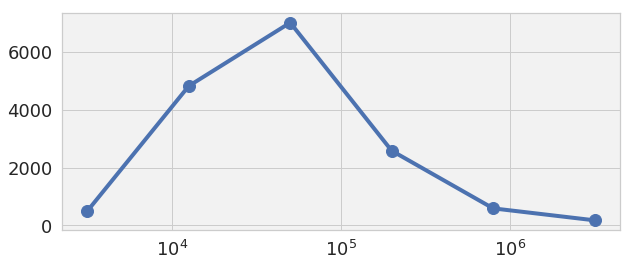

In [30]:
plt.figure(figsize=(10,4))
print lambdas
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')

## Validation

In [31]:
val_pred = fwrf.get_prediction(\
        _sfmaps, fmaps_sizes, [_X,], [val_stim_data,],\
        best_rf_params, best_w_params, best_avg, best_std,\
        _log_act_func, lx, sample_batch_size, voxel_batch_size)

ref_val_cc = np.zeros(shape=(nvv,), dtype=fpX)    
for v in tqdm(range(nvv)):    
    ref_val_cc[v] = np.corrcoef(val_pred[:,v], val_vpc_data[:,v])[0,1]

COMPILING
1.08 seconds to compile theano functions
CREATING SYMBOLS

> feature map candidates 0 with shape (500, 1, 55, 55)
> feature map candidates 1 with shape (500, 1, 27, 27)
> feature map candidates 2 with shape (500, 1, 13, 13)
> feature map candidates 3 with shape (500, 1, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 7.5 Mb of memory (VRAM and RAM)


100%|██████████| 15660/15660 [00:02<00:00, 7626.33it/s]


max cc = 0.729217
sum(cc>0.05) = 14334 of 15660


Text(0,0.5,'Relative frequency')

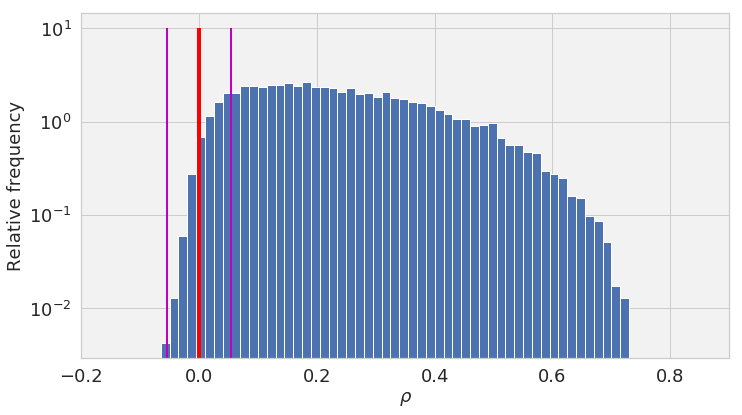

In [47]:
cc_th = 0.054
print "max cc = %f" % np.max(ref_val_cc)
print "sum(cc>%.2f) = %d of %d" % (cc_th, np.sum(map(lambda x: x > cc_th, ref_val_cc)), nvv)
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
plt.subplot(1,2,1)
_=plt.hist(ref_val_cc, bins=100, density=True, range=(-.5, 1.))
plt.vlines(x=[0], ymin=0, ymax=10, color='r', lw=4)
plt.vlines(x=[-cc_th, cc_th], ymin=0, ymax=10, color='m', lw=2)
plt.yscale('log')
plt.xlim([-.2, 0.9])
plt.xlabel(r'$\rho$')
plt.ylabel('Relative frequency')

## Save results

In [52]:
ex_file_name = "dnn_fwrf_%s_data" % (timestamp)
print ex_file_name
ex_values = {'voxel_order': voxel_order,
             'voxel_index': vpc_idx,
             'voxel_roi': vpc_roi,
             'rf_params': best_rf_params,
             'w_params_0': best_w_params[0],
             'w_params_1': best_w_params[1],
             'lambdas': lambdas, 
             'best_lambdas': best_lambdas,
             'normavg': best_avg,
             'normstd': best_std, 
             'val_cc': ref_val_cc}

save_stuff(output_dir + ex_file_name, ex_values)

dnn_fwrf_Nov-11-2019_1837_data
saved w_params_0 in h5py file
saved normstd in h5py file
saved best_lambdas in h5py file
saved voxel_order in h5py file
saved lambdas in h5py file
saved rf_params in h5py file
saved voxel_index in h5py file
saved normavg in h5py file
saved w_params_1 in h5py file
saved val_cc in h5py file
saved voxel_roi in h5py file


# Null hypothesis

In [38]:
null_val_cc = np.zeros(shape=(10, nvv), dtype=fpX)
for i in range(10):
    shuff = np.arange(len(val_pred))
    np.random.shuffle(shuff)
    shuffled_val_pred = val_pred[shuff]
    for v in tqdm(range(nvv)):    
        null_val_cc[i,v] = np.corrcoef(shuffled_val_pred[:,v], val_vpc_data[:,v])[0,1]

100%|██████████| 15660/15660 [00:01<00:00, 10333.11it/s]


std = 0.054


Text(0,0.5,'Relative frequency')

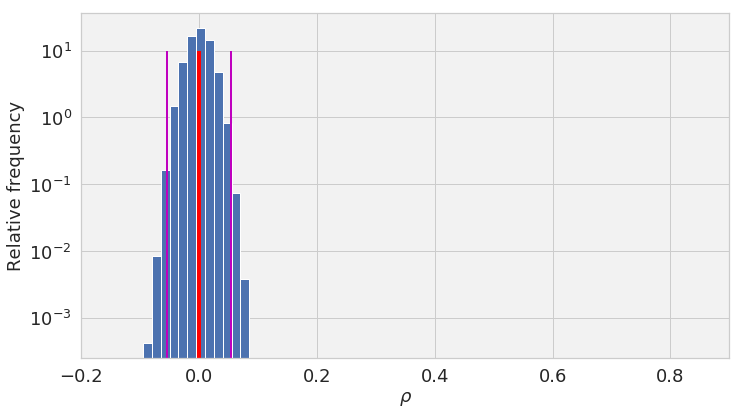

In [46]:
cc_th = 3* np.std(null_val_cc.flatten())
print 'std = %.3f' % cc_th
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
plt.subplot(1,2,1)
plt.hist(null_val_cc.flatten(), bins=100, density=True, range=(-.5, 1.))
plt.vlines(x=[0], ymin=0, ymax=10, color='r', lw=4)
plt.vlines(x=[-cc_th, cc_th], ymin=0, ymax=10, color='m', lw=2)
plt.yscale('log')
plt.xlim([-.2, 0.9])
plt.xlabel(r'$\rho$')
plt.ylabel('Relative frequency')

In [53]:
trn_sizes = np.array([1,2,3,6,9,18,27]) * 1000
holdout_perc = .1
ho_sizes = np.floor(holdout_perc * trn_sizes).astype(int)
print trn_sizes

[ 1000  2000  3000  6000  9000 18000 27000]


In [54]:
log_act_func = lambda x: np.log(1+np.abs(x))*np.tanh(np.abs(x)) #np.log(1+np.sqrt(np.abs(x)))
_log_act_func = lambda _x: T.log(fpX(1)+T.abs_(_x))*T.tanh(T.abs_(_x)) #T.log(fpX(1)+T.sqrt(T.abs_(_x)))
    
sample_batch_size = 200
voxel_batch_size = 500
model_batch_size = 32
model_minibatch_size = 8
holdout_size = 1000
lambdas = np.logspace(3.5,6.5,6)

characteristics = {'trn_sizes': trn_sizes,
                  'ho_sizes': ho_sizes,
                  'voxel_order': voxel_order,
                  'voxel_index': vpc_idx,
                  'voxel_roi': vpc_roi,
                  'lambdas': lambdas}
###
for k,(ts,hs) in enumerate(zip(trn_sizes, ho_sizes)):
    # training
    best_scores, best_lambdas, best_w_params, best_rf_params, best_avg, best_std = \
        fwrf.batched_learn_params_ridge_regression(\
            _sfmaps, fmaps_sizes, [_X,],
            [trn_stim_data[:ts],], trn_vpc_data[:ts], models, lambdas, sample_batch_size, voxel_batch_size, model_batch_size, model_minibatch_size,
            hs, add_bias=True, mst_nonlinearity=log_act_func)
    # validation
    val_pred = fwrf.get_prediction(\
            _sfmaps, fmaps_sizes, [_X,], [val_stim_data,],\
            best_rf_params, best_w_params, best_avg, best_std,\
            _log_act_func, lx, sample_batch_size, voxel_batch_size)
    # prediction accuracy
    val_cc = np.zeros(shape=(nvv,), dtype=fpX)    
    for v in tqdm(range(nvv)):    
        val_cc[v] = np.corrcoef(val_pred[:,v], val_vpc_data[:,v])[0,1]
    # save results    
    characteristics['result%d'%k] = {'trn_size': ts,
                          'best_lambdas': best_lambdas,
                          'val_cc': val_cc}
    # print a summary
    print ('================================================')
    print ('median cc = %.3f, max cc = %.3f' % (np.median(val_cc), np.max(val_cc)))
    print ('================================================')

==> Candidate block 0--31 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...
1.40 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.91s/it]

32 mst candidate responses took 7.660s @ 4.177 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.59it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.59it/s]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [02:59<00:00,  5.61s/it]


-------------------------
total time = 179.442253s
total throughput = 0.011459s/voxel
voxel throughput = 0.002129s/voxel
setup throughput = 4.565605s/candidate
==> Candidate block 32--63 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...
1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.94s/it]

32 mst candidate responses took 7.753s @ 4.128 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.59it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.65it/s]


COMPILING
0.54 seconds to compile theano functions


100%|██████████| 32/32 [02:56<00:00,  5.53s/it]

-------------------------
total time = 176.856778s
total throughput = 0.011294s/voxel
voxel throughput = 0.002053s/voxel
setup throughput = 4.521993s/candidate
==> Candidate block 64--95 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...
1.41 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.94s/it]

32 mst candidate responses took 7.772s @ 4.117 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.53it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.62it/s]


COMPILING
0.36 seconds to compile theano functions


100%|██████████| 32/32 [02:52<00:00,  5.40s/it]

-------------------------
total time = 172.823351s
total throughput = 0.011036s/voxel
voxel throughput = 0.002024s/voxel
setup throughput = 4.410195s/candidate
==> Candidate block 96--127 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...


1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

32 mst candidate responses took 7.794s @ 4.106 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.62it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.62it/s]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [02:52<00:00,  5.39s/it]

-------------------------
total time = 172.431456s
total throughput = 0.011011s/voxel
voxel throughput = 0.002170s/voxel
setup throughput = 4.326393s/candidate
==> Candidate block 128--159 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...
1.39 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.95s/it]

32 mst candidate responses took 7.790s @ 4.108 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.62it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.62it/s]


COMPILING
0.54 seconds to compile theano functions


100%|██████████| 32/32 [02:49<00:00,  5.28s/it]

-------------------------
total time = 169.059110s
total throughput = 0.010796s/voxel
voxel throughput = 0.002030s/voxel
setup throughput = 4.289733s/candidate
==> Candidate block 160--191 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...


1.40 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.94s/it]

32 mst candidate responses took 7.754s @ 4.127 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.62it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.66it/s]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [02:47<00:00,  5.23s/it]

-------------------------
total time = 167.346718s
total throughput = 0.010686s/voxel
voxel throughput = 0.001982s/voxel
setup throughput = 4.259767s/candidate
==> Candidate block 192--223 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...


1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.96s/it]

32 mst candidate responses took 7.834s @ 4.085 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.59it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.62it/s]


COMPILING
0.49 seconds to compile theano functions


100%|██████████| 32/32 [02:48<00:00,  5.27s/it]

-------------------------
total time = 168.747862s
total throughput = 0.010776s/voxel
voxel throughput = 0.002110s/voxel
setup throughput = 4.240881s/candidate
==> Candidate block 224--255 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...


1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.94s/it]

32 mst candidate responses took 7.781s @ 4.112 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.62it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.59it/s]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [02:46<00:00,  5.21s/it]

-------------------------
total time = 166.594849s
total throughput = 0.010638s/voxel
voxel throughput = 0.001987s/voxel
setup throughput = 4.233468s/candidate
==> Candidate block 256--287 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...


1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.94s/it]

32 mst candidate responses took 7.768s @ 4.119 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.59it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.66it/s]


COMPILING
0.33 seconds to compile theano functions


100%|██████████| 32/32 [02:47<00:00,  5.23s/it]

-------------------------
total time = 167.388003s
total throughput = 0.010689s/voxel
voxel throughput = 0.002001s/voxel
setup throughput = 4.251524s/candidate
==> Candidate block 288--319 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...


1.44 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.94s/it]

32 mst candidate responses took 7.781s @ 4.113 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.59it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.66it/s]


COMPILING
0.54 seconds to compile theano functions


100%|██████████| 32/32 [02:48<00:00,  5.28s/it]

-------------------------
total time = 168.935873s
total throughput = 0.010788s/voxel
voxel throughput = 0.002095s/voxel
setup throughput = 4.254056s/candidate
==> Candidate block 320--351 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...


1.41 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.97s/it]

32 mst candidate responses took 7.871s @ 4.066 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.59it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.66it/s]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [02:48<00:00,  5.27s/it]

-------------------------
total time = 168.577688s
total throughput = 0.010765s/voxel
voxel throughput = 0.002029s/voxel
setup throughput = 4.275276s/candidate
==> Candidate block 352--383 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.347Gb of RAM!
>> Will be divided in chunks of 0.087Gb of VRAM!

COMPILING...


1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:07<00:00,  1.96s/it]

32 mst candidate responses took 7.827s @ 4.088 models/s
Applying nonlinearity to modelspace tensor...



4it [00:02,  1.62it/s]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:02,  1.69it/s]


COMPILING
0.56 seconds to compile theano functions


100%|██████████| 32/32 [02:45<00:00,  5.16s/it]


-------------------------
total time = 165.277865s
total throughput = 0.010554s/voxel
voxel throughput = 0.001854s/voxel
setup throughput = 4.257614s/candidate
COMPILING
0.91 seconds to compile theano functions
CREATING SYMBOLS

> feature map candidates 0 with shape (500, 1, 55, 55)
> feature map candidates 1 with shape (500, 1, 27, 27)
> feature map candidates 2 with shape (500, 1, 13, 13)
> feature map candidates 3 with shape (500, 1, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 7.5 Mb of memory (VRAM and RAM)


100%|██████████| 15660/15660 [00:02<00:00, 7628.48it/s]


==> Candidate block 0--31 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.96s/it]

32 mst candidate responses took 15.829s @ 2.022 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.22s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.23s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [03:04<00:00,  5.78s/it]


-------------------------
total time = 184.881432s
total throughput = 0.011806s/voxel
voxel throughput = 0.003048s/voxel
setup throughput = 4.286169s/candidate
==> Candidate block 32--63 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]

32 mst candidate responses took 15.620s @ 2.049 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.23s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.21s/it]


COMPILING
0.50 seconds to compile theano functions


100%|██████████| 32/32 [03:03<00:00,  5.74s/it]


-------------------------
total time = 183.590916s
total throughput = 0.011724s/voxel
voxel throughput = 0.002950s/voxel
setup throughput = 4.293650s/candidate
==> Candidate block 64--95 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...
1.39 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.89s/it]

32 mst candidate responses took 15.548s @ 2.058 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.23s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.21s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [03:02<00:00,  5.70s/it]

-------------------------
total time = 182.432170s
total throughput = 0.011650s/voxel
voxel throughput = 0.002928s/voxel
setup throughput = 4.268110s/candidate
==> Candidate block 96--127 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...
1.39 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.92s/it]

32 mst candidate responses took 15.678s @ 2.041 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.24s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.21s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [03:05<00:00,  5.79s/it]

-------------------------
total time = 185.292066s
total throughput = 0.011832s/voxel
voxel throughput = 0.003066s/voxel
setup throughput = 4.290114s/candidate
==> Candidate block 128--159 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...
1.40 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.92s/it]

32 mst candidate responses took 15.668s @ 2.042 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.23s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.18s/it]


COMPILING
0.54 seconds to compile theano functions


100%|██████████| 32/32 [03:03<00:00,  5.73s/it]

-------------------------
total time = 183.486260s
total throughput = 0.011717s/voxel
voxel throughput = 0.002962s/voxel
setup throughput = 4.284636s/candidate
==> Candidate block 160--191 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...


1.39 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]

32 mst candidate responses took 15.613s @ 2.050 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.24s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:05,  1.26s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [03:05<00:00,  5.80s/it]

-------------------------
total time = 185.612937s
total throughput = 0.011853s/voxel
voxel throughput = 0.003044s/voxel
setup throughput = 4.310933s/candidate
==> Candidate block 192--223 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.92s/it]

32 mst candidate responses took 15.676s @ 2.041 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.24s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.24s/it]


COMPILING
0.52 seconds to compile theano functions


100%|██████████| 32/32 [03:07<00:00,  5.87s/it]

-------------------------
total time = 187.975621s
total throughput = 0.012004s/voxel
voxel throughput = 0.003165s/voxel
setup throughput = 4.325133s/candidate
==> Candidate block 224--255 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.90s/it]

32 mst candidate responses took 15.614s @ 2.049 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.23s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.19s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [03:05<00:00,  5.81s/it]

-------------------------
total time = 185.957694s
total throughput = 0.011875s/voxel
voxel throughput = 0.003032s/voxel
setup throughput = 4.327314s/candidate
==> Candidate block 256--287 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...


1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.92s/it]

32 mst candidate responses took 15.687s @ 2.040 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.24s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.22s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [03:04<00:00,  5.78s/it]

-------------------------
total time = 184.938610s
total throughput = 0.011810s/voxel
voxel throughput = 0.003053s/voxel
setup throughput = 4.285122s/candidate
==> Candidate block 288--319 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...


1.48 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.92s/it]

32 mst candidate responses took 15.672s @ 2.042 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.24s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.19s/it]


COMPILING
0.54 seconds to compile theano functions


100%|██████████| 32/32 [03:06<00:00,  5.81s/it]

-------------------------
total time = 186.030148s
total throughput = 0.011879s/voxel
voxel throughput = 0.003183s/voxel
setup throughput = 4.255739s/candidate
==> Candidate block 320--351 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...


1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.92s/it]

32 mst candidate responses took 15.696s @ 2.039 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.22s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.21s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [02:26<00:00,  4.56s/it]

-------------------------
total time = 146.079289s
total throughput = 0.009328s/voxel
voxel throughput = 0.002900s/voxel
setup throughput = 3.145986s/candidate
==> Candidate block 352--383 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 0.694Gb of RAM!
>> Will be divided in chunks of 0.174Gb of VRAM!

COMPILING...


1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:15<00:00,  3.87s/it]

32 mst candidate responses took 15.475s @ 2.068 models/s
Applying nonlinearity to modelspace tensor...



4it [00:04,  1.21s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:04,  1.19s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [02:29<00:00,  4.66s/it]


-------------------------
total time = 149.035459s
total throughput = 0.009517s/voxel
voxel throughput = 0.003044s/voxel
setup throughput = 3.167736s/candidate
COMPILING
1.15 seconds to compile theano functions
CREATING SYMBOLS

> feature map candidates 0 with shape (500, 1, 55, 55)
> feature map candidates 1 with shape (500, 1, 27, 27)
> feature map candidates 2 with shape (500, 1, 13, 13)
> feature map candidates 3 with shape (500, 1, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 7.5 Mb of memory (VRAM and RAM)


100%|██████████| 15660/15660 [00:02<00:00, 7627.92it/s]


==> Candidate block 0--31 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:23<00:00,  5.82s/it]

32 mst candidate responses took 23.280s @ 1.375 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.82s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.82s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [02:47<00:00,  5.23s/it]


-------------------------
total time = 167.482403s
total throughput = 0.010695s/voxel
voxel throughput = 0.004114s/voxel
setup throughput = 3.220666s/candidate
==> Candidate block 32--63 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...
1.40 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:23<00:00,  5.80s/it]

32 mst candidate responses took 23.193s @ 1.380 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.82s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.78s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [02:44<00:00,  5.13s/it]


-------------------------
total time = 164.091788s
total throughput = 0.010478s/voxel
voxel throughput = 0.003941s/voxel
setup throughput = 3.199294s/candidate
==> Candidate block 64--95 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...
1.58 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:23<00:00,  5.80s/it]

32 mst candidate responses took 23.187s @ 1.380 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.84s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.82s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [02:44<00:00,  5.14s/it]


-------------------------
total time = 164.576783s
total throughput = 0.010509s/voxel
voxel throughput = 0.003937s/voxel
setup throughput = 3.216160s/candidate
==> Candidate block 96--127 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...
1.42 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:23<00:00,  5.76s/it]

32 mst candidate responses took 23.040s @ 1.389 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.84s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.84s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [02:47<00:00,  5.23s/it]

-------------------------
total time = 167.231744s
total throughput = 0.010679s/voxel
voxel throughput = 0.004125s/voxel
setup throughput = 3.207425s/candidate
==> Candidate block 128--159 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...
1.34 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:23<00:00,  5.76s/it]

32 mst candidate responses took 23.039s @ 1.389 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.83s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.83s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [02:43<00:00,  5.12s/it]

-------------------------
total time = 163.725571s
total throughput = 0.010455s/voxel
voxel throughput = 0.003935s/voxel
setup throughput = 3.190923s/candidate
==> Candidate block 160--191 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...
1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:23<00:00,  5.79s/it]

32 mst candidate responses took 23.175s @ 1.381 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.84s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.81s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [02:46<00:00,  5.22s/it]

-------------------------
total time = 166.981122s
total throughput = 0.010663s/voxel
voxel throughput = 0.004037s/voxel
setup throughput = 3.242578s/candidate
==> Candidate block 192--223 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...


1.41 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:23<00:00,  5.80s/it]

32 mst candidate responses took 23.204s @ 1.379 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.84s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.82s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [02:50<00:00,  5.32s/it]

-------------------------
total time = 170.119052s
total throughput = 0.010863s/voxel
voxel throughput = 0.004232s/voxel
setup throughput = 3.245289s/candidate
==> Candidate block 224--255 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:23<00:00,  5.76s/it]

32 mst candidate responses took 23.041s @ 1.389 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.84s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.84s/it]


COMPILING
0.53 seconds to compile theano functions


100%|██████████| 32/32 [02:46<00:00,  5.22s/it]

-------------------------
total time = 166.981439s
total throughput = 0.010663s/voxel
voxel throughput = 0.004039s/voxel
setup throughput = 3.241721s/candidate
==> Candidate block 256--287 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...


1.39 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:22<00:00,  5.75s/it]

32 mst candidate responses took 22.997s @ 1.391 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.84s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.83s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [02:47<00:00,  5.23s/it]

-------------------------
total time = 167.238202s
total throughput = 0.010679s/voxel
voxel throughput = 0.004071s/voxel
setup throughput = 3.233876s/candidate
==> Candidate block 288--319 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...


1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:22<00:00,  5.75s/it]

32 mst candidate responses took 22.998s @ 1.391 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.84s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.86s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [02:46<00:00,  5.20s/it]

-------------------------
total time = 166.331056s
total throughput = 0.010621s/voxel
voxel throughput = 0.004078s/voxel
setup throughput = 3.202065s/candidate
==> Candidate block 320--351 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...


1.35 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:23<00:00,  5.76s/it]

32 mst candidate responses took 23.027s @ 1.390 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.83s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.82s/it]


COMPILING
0.53 seconds to compile theano functions


100%|██████████| 32/32 [02:46<00:00,  5.21s/it]

-------------------------
total time = 166.681155s
total throughput = 0.010644s/voxel
voxel throughput = 0.004049s/voxel
setup throughput = 3.227233s/candidate
==> Candidate block 352--383 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 1.041Gb of RAM!
>> Will be divided in chunks of 0.260Gb of VRAM!

COMPILING...


1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:23<00:00,  5.75s/it]

32 mst candidate responses took 23.024s @ 1.390 models/s
Applying nonlinearity to modelspace tensor...



4it [00:07,  1.81s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:07,  1.84s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [02:44<00:00,  5.13s/it]


-------------------------
total time = 164.029336s
total throughput = 0.010474s/voxel
voxel throughput = 0.003921s/voxel
setup throughput = 3.207159s/candidate
COMPILING
1.12 seconds to compile theano functions
CREATING SYMBOLS

> feature map candidates 0 with shape (500, 1, 55, 55)
> feature map candidates 1 with shape (500, 1, 27, 27)
> feature map candidates 2 with shape (500, 1, 13, 13)
> feature map candidates 3 with shape (500, 1, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 7.5 Mb of memory (VRAM and RAM)


100%|██████████| 15660/15660 [00:02<00:00, 7632.04it/s]


==> Candidate block 0--31 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.56s/it]

32 mst candidate responses took 46.229s @ 0.692 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.62s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.52s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [03:46<00:00,  7.08s/it]


-------------------------
total time = 226.481652s
total throughput = 0.014462s/voxel
voxel throughput = 0.007392s/voxel
setup throughput = 3.460101s/candidate
==> Candidate block 32--63 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...
1.50 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.54s/it]

32 mst candidate responses took 46.185s @ 0.693 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.63s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.69s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [03:47<00:00,  7.10s/it]


-------------------------
total time = 227.288158s
total throughput = 0.014514s/voxel
voxel throughput = 0.007456s/voxel
setup throughput = 3.454198s/candidate
==> Candidate block 64--95 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.54s/it]

32 mst candidate responses took 46.182s @ 0.693 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.68s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.59s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [03:45<00:00,  7.06s/it]

-------------------------
total time = 225.931232s
total throughput = 0.014427s/voxel
voxel throughput = 0.007409s/voxel
setup throughput = 3.434579s/candidate
==> Candidate block 96--127 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...
1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.54s/it]

32 mst candidate responses took 46.182s @ 0.693 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.67s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.59s/it]


COMPILING
0.54 seconds to compile theano functions


100%|██████████| 32/32 [03:48<00:00,  7.15s/it]


-------------------------
total time = 228.885451s
total throughput = 0.014616s/voxel
voxel throughput = 0.007574s/voxel
setup throughput = 3.445912s/candidate
==> Candidate block 128--159 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...
1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.53s/it]

32 mst candidate responses took 46.107s @ 0.694 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.65s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.57s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [03:47<00:00,  7.10s/it]

-------------------------
total time = 227.332921s
total throughput = 0.014517s/voxel
voxel throughput = 0.007427s/voxel
setup throughput = 3.469343s/candidate
==> Candidate block 160--191 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...
1.35 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.54s/it]

32 mst candidate responses took 46.156s @ 0.693 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.68s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.56s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [03:45<00:00,  7.05s/it]

-------------------------
total time = 225.730100s
total throughput = 0.014414s/voxel
voxel throughput = 0.007383s/voxel
setup throughput = 3.440938s/candidate
==> Candidate block 192--223 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...
1.35 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.63s/it]

32 mst candidate responses took 46.540s @ 0.688 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.67s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.57s/it]


COMPILING
0.53 seconds to compile theano functions


100%|██████████| 32/32 [03:48<00:00,  7.14s/it]

-------------------------
total time = 228.636074s
total throughput = 0.014600s/voxel
voxel throughput = 0.007590s/voxel
setup throughput = 3.430284s/candidate
==> Candidate block 224--255 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.55s/it]

32 mst candidate responses took 46.189s @ 0.693 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.66s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.54s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [03:47<00:00,  7.10s/it]

-------------------------
total time = 227.139557s
total throughput = 0.014504s/voxel
voxel throughput = 0.007414s/voxel
setup throughput = 3.469735s/candidate
==> Candidate block 256--287 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...


1.41 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.55s/it]

32 mst candidate responses took 46.193s @ 0.693 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.67s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.61s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [03:45<00:00,  7.05s/it]

-------------------------
total time = 225.734363s
total throughput = 0.014415s/voxel
voxel throughput = 0.007389s/voxel
setup throughput = 3.438064s/candidate
==> Candidate block 288--319 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...


1.61 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.62s/it]

32 mst candidate responses took 46.477s @ 0.689 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.67s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.53s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [03:46<00:00,  7.09s/it]

-------------------------
total time = 226.836837s
total throughput = 0.014485s/voxel
voxel throughput = 0.007505s/voxel
setup throughput = 3.415761s/candidate
==> Candidate block 320--351 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...


1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.59s/it]

32 mst candidate responses took 46.344s @ 0.690 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.63s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.52s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [03:46<00:00,  7.07s/it]

-------------------------
total time = 226.381292s
total throughput = 0.014456s/voxel
voxel throughput = 0.007409s/voxel
setup throughput = 3.448469s/candidate
==> Candidate block 352--383 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.083Gb of RAM!
>> Will be divided in chunks of 0.521Gb of VRAM!

COMPILING...


1.39 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [00:46<00:00, 11.55s/it]

32 mst candidate responses took 46.200s @ 0.693 models/s
Applying nonlinearity to modelspace tensor...



4it [00:14,  3.60s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:14,  3.68s/it]


COMPILING
0.53 seconds to compile theano functions


100%|██████████| 32/32 [03:46<00:00,  7.09s/it]


-------------------------
total time = 226.936077s
total throughput = 0.014491s/voxel
voxel throughput = 0.007420s/voxel
setup throughput = 3.460420s/candidate
COMPILING
0.90 seconds to compile theano functions
CREATING SYMBOLS

> feature map candidates 0 with shape (500, 1, 55, 55)
> feature map candidates 1 with shape (500, 1, 27, 27)
> feature map candidates 2 with shape (500, 1, 13, 13)
> feature map candidates 3 with shape (500, 1, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 7.5 Mb of memory (VRAM and RAM)


100%|██████████| 15660/15660 [00:02<00:00, 7638.83it/s]


==> Candidate block 0--31 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...
1.39 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.37s/it]

32 mst candidate responses took 69.475s @ 0.461 models/s
Applying nonlinearity to modelspace tensor...



4it [00:21,  5.42s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.25s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [04:43<00:00,  8.87s/it]


-------------------------
total time = 283.978844s
total throughput = 0.018134s/voxel
voxel throughput = 0.010658s/voxel
setup throughput = 3.658580s/candidate
==> Candidate block 32--63 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:10<00:00, 17.57s/it]

32 mst candidate responses took 70.303s @ 0.455 models/s
Applying nonlinearity to modelspace tensor...



4it [00:21,  5.44s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.34s/it]


COMPILING
0.54 seconds to compile theano functions


100%|██████████| 32/32 [04:42<00:00,  8.81s/it]


-------------------------
total time = 282.075336s
total throughput = 0.018012s/voxel
voxel throughput = 0.010567s/voxel
setup throughput = 3.643606s/candidate
==> Candidate block 64--95 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...
1.39 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.45s/it]

32 mst candidate responses took 69.817s @ 0.458 models/s
Applying nonlinearity to modelspace tensor...



4it [00:22,  5.50s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.42s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [04:43<00:00,  8.87s/it]


-------------------------
total time = 283.778126s
total throughput = 0.018121s/voxel
voxel throughput = 0.010664s/voxel
setup throughput = 3.649521s/candidate
==> Candidate block 96--127 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.35s/it]

32 mst candidate responses took 69.396s @ 0.461 models/s
Applying nonlinearity to modelspace tensor...



4it [00:21,  5.49s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.33s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [04:46<00:00,  8.97s/it]


-------------------------
total time = 286.883919s
total throughput = 0.018320s/voxel
voxel throughput = 0.010858s/voxel
setup throughput = 3.651293s/candidate
==> Candidate block 128--159 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.35s/it]

32 mst candidate responses took 69.407s @ 0.461 models/s
Applying nonlinearity to modelspace tensor...



4it [00:21,  5.49s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.25s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [04:44<00:00,  8.89s/it]

-------------------------
total time = 284.630219s
total throughput = 0.018176s/voxel
voxel throughput = 0.010692s/voxel
setup throughput = 3.662057s/candidate
==> Candidate block 160--191 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...
1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.35s/it]

32 mst candidate responses took 69.414s @ 0.461 models/s
Applying nonlinearity to modelspace tensor...



4it [00:21,  5.48s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.38s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [04:43<00:00,  8.86s/it]

-------------------------
total time = 283.627662s
total throughput = 0.018112s/voxel
voxel throughput = 0.010634s/voxel
setup throughput = 3.659381s/candidate
==> Candidate block 192--223 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...
1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.41s/it]

32 mst candidate responses took 69.652s @ 0.459 models/s
Applying nonlinearity to modelspace tensor...



4it [00:21,  5.49s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.29s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [04:47<00:00,  8.98s/it]

-------------------------
total time = 287.235703s
total throughput = 0.018342s/voxel
voxel throughput = 0.010871s/voxel
setup throughput = 3.655995s/candidate
==> Candidate block 224--255 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...
1.35 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.33s/it]

32 mst candidate responses took 69.338s @ 0.462 models/s
Applying nonlinearity to modelspace tensor...



4it [00:21,  5.48s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.28s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [04:43<00:00,  8.85s/it]

-------------------------
total time = 283.327589s
total throughput = 0.018092s/voxel
voxel throughput = 0.010638s/voxel
setup throughput = 3.647977s/candidate
==> Candidate block 256--287 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...
1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.42s/it]

32 mst candidate responses took 69.702s @ 0.459 models/s
Applying nonlinearity to modelspace tensor...



4it [00:21,  5.49s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.42s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [04:44<00:00,  8.89s/it]

-------------------------
total time = 284.429579s
total throughput = 0.018163s/voxel
voxel throughput = 0.010657s/voxel
setup throughput = 3.673129s/candidate
==> Candidate block 288--319 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...


1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.45s/it]

32 mst candidate responses took 69.788s @ 0.459 models/s
Applying nonlinearity to modelspace tensor...



4it [00:22,  5.50s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.39s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [04:44<00:00,  8.91s/it]

-------------------------
total time = 284.981562s
total throughput = 0.018198s/voxel
voxel throughput = 0.010754s/voxel
setup throughput = 3.642895s/candidate
==> Candidate block 320--351 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...


1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.33s/it]

32 mst candidate responses took 69.322s @ 0.462 models/s
Applying nonlinearity to modelspace tensor...



4it [00:21,  5.44s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.28s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [04:43<00:00,  8.86s/it]

-------------------------
total time = 283.628796s
total throughput = 0.018112s/voxel
voxel throughput = 0.010649s/voxel
setup throughput = 3.652057s/candidate
==> Candidate block 352--383 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 3.124Gb of RAM!
>> Will be divided in chunks of 0.781Gb of VRAM!

COMPILING...


1.39 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [01:09<00:00, 17.33s/it]

32 mst candidate responses took 69.322s @ 0.462 models/s
Applying nonlinearity to modelspace tensor...



4it [00:21,  5.40s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:21,  5.29s/it]


COMPILING
0.53 seconds to compile theano functions


100%|██████████| 32/32 [04:43<00:00,  8.85s/it]


-------------------------
total time = 283.226731s
total throughput = 0.018086s/voxel
voxel throughput = 0.010622s/voxel
setup throughput = 3.652804s/candidate
COMPILING
1.13 seconds to compile theano functions
CREATING SYMBOLS

> feature map candidates 0 with shape (500, 1, 55, 55)
> feature map candidates 1 with shape (500, 1, 27, 27)
> feature map candidates 2 with shape (500, 1, 13, 13)
> feature map candidates 3 with shape (500, 1, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 7.5 Mb of memory (VRAM and RAM)


100%|██████████| 15660/15660 [00:02<00:00, 7785.88it/s]


==> Candidate block 0--31 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...
1.56 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:20<00:00, 35.09s/it]

32 mst candidate responses took 140.352s @ 0.228 models/s
Applying nonlinearity to modelspace tensor...



4it [00:43, 10.83s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:42, 10.70s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [07:44<00:00, 14.50s/it]


-------------------------
total time = 464.032131s
total throughput = 0.029632s/voxel
voxel throughput = 0.020719s/voxel
setup throughput = 4.361577s/candidate
==> Candidate block 32--63 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...
1.57 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:20<00:00, 35.10s/it]

32 mst candidate responses took 140.394s @ 0.228 models/s
Applying nonlinearity to modelspace tensor...



4it [00:43, 10.85s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:43, 10.83s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [07:41<00:00, 14.44s/it]


-------------------------
total time = 461.929274s
total throughput = 0.029497s/voxel
voxel throughput = 0.020665s/voxel
setup throughput = 4.322163s/candidate
==> Candidate block 64--95 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...
1.40 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:19<00:00, 34.78s/it]

32 mst candidate responses took 139.129s @ 0.230 models/s
Applying nonlinearity to modelspace tensor...



4it [00:43, 10.98s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:42, 10.70s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [07:41<00:00, 14.43s/it]


-------------------------
total time = 461.878956s
total throughput = 0.029494s/voxel
voxel throughput = 0.020642s/voxel
setup throughput = 4.331825s/candidate
==> Candidate block 96--127 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...
1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:19<00:00, 34.98s/it]

32 mst candidate responses took 139.939s @ 0.229 models/s
Applying nonlinearity to modelspace tensor...



4it [00:44, 11.02s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:42, 10.50s/it]


COMPILING
0.49 seconds to compile theano functions


100%|██████████| 32/32 [07:46<00:00, 14.58s/it]


-------------------------
total time = 466.687466s
total throughput = 0.029801s/voxel
voxel throughput = 0.020945s/voxel
setup throughput = 4.333835s/candidate
==> Candidate block 128--159 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:19<00:00, 34.79s/it]

32 mst candidate responses took 139.176s @ 0.230 models/s
Applying nonlinearity to modelspace tensor...



4it [00:43, 10.95s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:42, 10.60s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [07:41<00:00, 14.43s/it]

-------------------------
total time = 461.778440s
total throughput = 0.029488s/voxel
voxel throughput = 0.020644s/voxel
setup throughput = 4.327790s/candidate
==> Candidate block 160--191 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:19<00:00, 34.97s/it]

32 mst candidate responses took 139.892s @ 0.229 models/s
Applying nonlinearity to modelspace tensor...



4it [00:43, 10.98s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:43, 10.83s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [07:41<00:00, 14.43s/it]


-------------------------
total time = 461.829232s
total throughput = 0.029491s/voxel
voxel throughput = 0.020621s/voxel
setup throughput = 4.340935s/candidate
==> Candidate block 192--223 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:19<00:00, 34.95s/it]

32 mst candidate responses took 139.802s @ 0.229 models/s
Applying nonlinearity to modelspace tensor...



4it [00:43, 10.98s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:43, 10.75s/it]


COMPILING
0.54 seconds to compile theano functions


100%|██████████| 32/32 [07:46<00:00, 14.57s/it]

-------------------------
total time = 466.136485s
total throughput = 0.029766s/voxel
voxel throughput = 0.020899s/voxel
setup throughput = 4.339330s/candidate
==> Candidate block 224--255 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:19<00:00, 34.95s/it]

32 mst candidate responses took 139.798s @ 0.229 models/s
Applying nonlinearity to modelspace tensor...



4it [00:43, 10.94s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:42, 10.68s/it]


COMPILING
0.33 seconds to compile theano functions


100%|██████████| 32/32 [07:40<00:00, 14.38s/it]

-------------------------
total time = 460.275714s
total throughput = 0.029392s/voxel
voxel throughput = 0.020529s/voxel
setup throughput = 4.337043s/candidate
==> Candidate block 256--287 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...


1.35 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:19<00:00, 34.96s/it]

32 mst candidate responses took 139.835s @ 0.229 models/s
Applying nonlinearity to modelspace tensor...



4it [00:43, 10.95s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:42, 10.63s/it]


COMPILING
0.49 seconds to compile theano functions


100%|██████████| 32/32 [07:40<00:00, 14.39s/it]

-------------------------
total time = 460.626242s
total throughput = 0.029414s/voxel
voxel throughput = 0.020549s/voxel
setup throughput = 4.338537s/candidate
==> Candidate block 288--319 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...


1.34 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:19<00:00, 34.96s/it]

32 mst candidate responses took 139.838s @ 0.229 models/s
Applying nonlinearity to modelspace tensor...



4it [00:44, 11.02s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:42, 10.55s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [07:44<00:00, 14.50s/it]

-------------------------
total time = 464.082776s
total throughput = 0.029635s/voxel
voxel throughput = 0.020711s/voxel
setup throughput = 4.366978s/candidate
==> Candidate block 320--351 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...


1.35 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:19<00:00, 34.76s/it]

32 mst candidate responses took 139.064s @ 0.230 models/s
Applying nonlinearity to modelspace tensor...



4it [00:43, 10.85s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:42, 10.54s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [07:41<00:00, 14.42s/it]

-------------------------
total time = 461.427710s
total throughput = 0.029465s/voxel
voxel throughput = 0.020615s/voxel
setup throughput = 4.330983s/candidate
==> Candidate block 352--383 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 6.248Gb of RAM!
>> Will be divided in chunks of 1.562Gb of VRAM!

COMPILING...


1.63 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [02:20<00:00, 35.02s/it]

32 mst candidate responses took 140.077s @ 0.228 models/s
Applying nonlinearity to modelspace tensor...



4it [00:43, 10.82s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [00:43, 10.92s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [07:40<00:00, 14.39s/it]


-------------------------
total time = 460.576830s
total throughput = 0.029411s/voxel
voxel throughput = 0.020536s/voxel
setup throughput = 4.343281s/candidate
COMPILING
1.13 seconds to compile theano functions
CREATING SYMBOLS

> feature map candidates 0 with shape (500, 1, 55, 55)
> feature map candidates 1 with shape (500, 1, 27, 27)
> feature map candidates 2 with shape (500, 1, 13, 13)
> feature map candidates 3 with shape (500, 1, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 7.5 Mb of memory (VRAM and RAM)


100%|██████████| 15660/15660 [00:02<00:00, 7754.33it/s]


==> Candidate block 0--31 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:28<00:00, 52.14s/it]

32 mst candidate responses took 208.560s @ 0.153 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.38s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:04, 16.07s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [10:43<00:00, 20.10s/it]


-------------------------
total time = 643.285189s
total throughput = 0.041078s/voxel
voxel throughput = 0.030754s/voxel
setup throughput = 5.052238s/candidate
==> Candidate block 32--63 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.52 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:28<00:00, 52.17s/it]

32 mst candidate responses took 208.696s @ 0.153 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.29s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:04, 16.14s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [10:39<00:00, 19.99s/it]


-------------------------
total time = 639.746653s
total throughput = 0.040852s/voxel
voxel throughput = 0.030603s/voxel
setup throughput = 5.015707s/candidate
==> Candidate block 64--95 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:28<00:00, 52.19s/it]

32 mst candidate responses took 208.771s @ 0.153 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.44s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:03, 15.86s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [10:40<00:00, 20.02s/it]


-------------------------
total time = 640.781469s
total throughput = 0.040918s/voxel
voxel throughput = 0.030568s/voxel
setup throughput = 5.065038s/candidate
==> Candidate block 96--127 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.39 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:28<00:00, 52.18s/it]

32 mst candidate responses took 208.708s @ 0.153 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.44s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:03, 15.97s/it]


COMPILING
0.54 seconds to compile theano functions


100%|██████████| 32/32 [10:42<00:00, 20.09s/it]


-------------------------
total time = 642.934699s
total throughput = 0.041056s/voxel
voxel throughput = 0.030822s/voxel
setup throughput = 5.008145s/candidate
==> Candidate block 128--159 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:28<00:00, 52.15s/it]

32 mst candidate responses took 208.598s @ 0.153 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.44s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:04, 16.24s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [10:40<00:00, 20.03s/it]


-------------------------
total time = 640.931316s
total throughput = 0.040928s/voxel
voxel throughput = 0.030639s/voxel
setup throughput = 5.035041s/candidate
==> Candidate block 160--191 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:30<00:00, 52.57s/it]

32 mst candidate responses took 210.280s @ 0.152 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.47s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:04, 16.11s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [10:39<00:00, 19.98s/it]


-------------------------
total time = 639.496397s
total throughput = 0.040836s/voxel
voxel throughput = 0.030593s/voxel
setup throughput = 5.012633s/candidate
==> Candidate block 192--223 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.36 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:29<00:00, 52.42s/it]

32 mst candidate responses took 209.685s @ 0.153 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.46s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:04, 16.03s/it]


COMPILING
0.53 seconds to compile theano functions


100%|██████████| 32/32 [10:42<00:00, 20.09s/it]


-------------------------
total time = 642.733169s
total throughput = 0.041043s/voxel
voxel throughput = 0.030819s/voxel
setup throughput = 5.003594s/candidate
==> Candidate block 224--255 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:29<00:00, 52.48s/it]

32 mst candidate responses took 209.933s @ 0.152 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.41s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:03, 15.78s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [10:39<00:00, 19.99s/it]

-------------------------
total time = 639.796227s
total throughput = 0.040855s/voxel
voxel throughput = 0.030582s/voxel
setup throughput = 5.027770s/candidate
==> Candidate block 256--287 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...


1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:29<00:00, 52.32s/it]

32 mst candidate responses took 209.269s @ 0.153 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.49s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:03, 15.97s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [10:40<00:00, 20.03s/it]

-------------------------
total time = 640.831521s
total throughput = 0.040922s/voxel
voxel throughput = 0.030584s/voxel
setup throughput = 5.058881s/candidate
==> Candidate block 288--319 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...


1.37 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:29<00:00, 52.40s/it]

32 mst candidate responses took 209.608s @ 0.153 models/s
Applying nonlinearity to modelspace tensor...



4it [01:06, 16.51s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:04, 16.06s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [10:43<00:00, 20.12s/it]

-------------------------
total time = 643.986669s
total throughput = 0.041123s/voxel
voxel throughput = 0.030797s/voxel
setup throughput = 5.053281s/candidate
==> Candidate block 320--351 of 384


CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...
1.40 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:29<00:00, 52.39s/it]

32 mst candidate responses took 209.581s @ 0.153 models/s
Applying nonlinearity to modelspace tensor...



4it [01:05, 16.31s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:03, 15.91s/it]


COMPILING
0.32 seconds to compile theano functions


100%|██████████| 32/32 [10:40<00:00, 20.02s/it]

-------------------------
total time = 640.731093s
total throughput = 0.040915s/voxel
voxel throughput = 0.030583s/voxel
setup throughput = 5.056120s/candidate
==> Candidate block 352--383 of 384
CREATING SYMBOLS

> feature map candidates 0 with shape (1, 8, 55, 55)
> feature map candidates 1 with shape (1, 8, 27, 27)
> feature map candidates 2 with shape (1, 8, 13, 13)
> feature map candidates 3 with shape (1, 8, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 0.1 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 9.373Gb of RAM!
>> Will be divided in chunks of 2.343Gb of VRAM!

COMPILING...


1.38 seconds to compile theano functions

Precomputing mst candidate responses...


100%|██████████| 4/4 [03:31<00:00, 52.82s/it]

32 mst candidate responses took 211.276s @ 0.151 models/s
Applying nonlinearity to modelspace tensor...



4it [01:04, 16.19s/it]

Z-scoring modelspace tensor...
Using self z-scoring values.



4it [01:03, 15.92s/it]


COMPILING
0.31 seconds to compile theano functions


100%|██████████| 32/32 [10:38<00:00, 19.96s/it]


-------------------------
total time = 638.695231s
total throughput = 0.040785s/voxel
voxel throughput = 0.030543s/voxel
setup throughput = 5.012286s/candidate
COMPILING
1.12 seconds to compile theano functions
CREATING SYMBOLS

> feature map candidates 0 with shape (500, 1, 55, 55)
> feature map candidates 1 with shape (500, 1, 27, 27)
> feature map candidates 2 with shape (500, 1, 13, 13)
> feature map candidates 3 with shape (500, 1, 1, 1)
  total number of feature maps = 2912, in 4 layers
  feature map candidate using approx 7.5 Mb of memory (VRAM and RAM)


100%|██████████| 15660/15660 [00:02<00:00, 7819.16it/s]


In [57]:
ex_file = open(output_dir + "dnn_fwrf_scaling_%s_data" % (timestamp), 'wb')
pickle.dump(characteristics, ex_file)
ex_file.close()

In [58]:
print characteristics.keys()

['result5', 'result6', 'voxel_roi', 'result3', 'result2', 'voxel_order', 'voxel_index', 'result1', 'trn_sizes', 'ho_sizes', 'result0', 'result4', 'lambdas']


In [114]:
from matplotlib.colors import Colormap
from matplotlib.cm import get_cmap
cmap = get_cmap('magma')

In [115]:
print cmap(0)

(0.001462, 0.000466, 0.013866, 1.0)


Text(0,0.5,'Count')

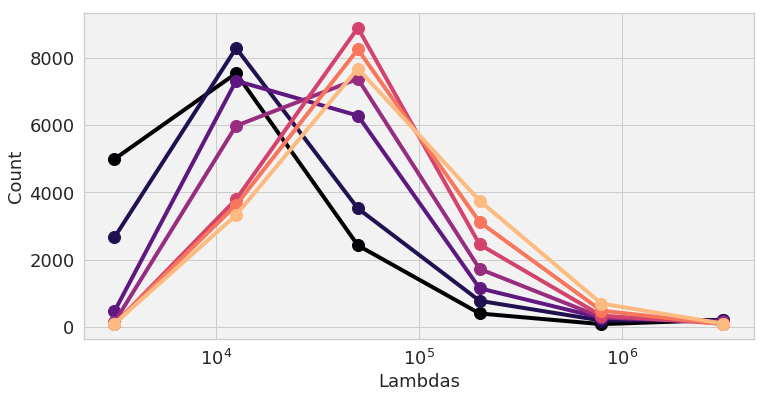

In [118]:
fig=plt.figure(figsize=(12,6))
for i,ts in enumerate(trn_sizes):
    plt.plot(lambdas, [np.sum(characteristics['result%d'%i]['best_lambdas']==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12, color=cmap(float(i)/len(trn_sizes)))
plt.xscale('log')
plt.xlabel('Lambdas')
plt.ylabel('Count')

In [119]:
filename = output_dir + "validation_lambdas_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 

In [67]:
result_cc, median_cc, top_cc, count_cc = [],[],[],[]
for i,ts in enumerate(trn_sizes):
    result_cc += [characteristics['result%d'%i]['val_cc'],]
    median_cc += [np.median(characteristics['result%d'%i]['val_cc'])]
    top_cc += [np.max(characteristics['result%d'%i]['val_cc'])]
    count_cc += [np.sum(characteristics['result%d'%i]['val_cc']>cc_th)]

Text(0,0.5,'Above threshold')

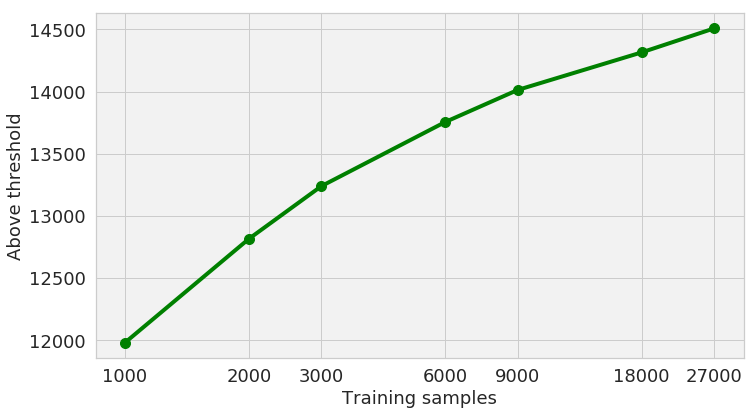

In [111]:
fig=plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
plt.subplot(1,2,1)
plt.plot(trn_sizes, count_cc, marker='o', ms=10, color='g', lw=4)
plt.xscale('log')
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Above threshold')

In [110]:
filename = output_dir + "validation_above_threshold_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 

Text(0,0.5,'Validation accuracies')

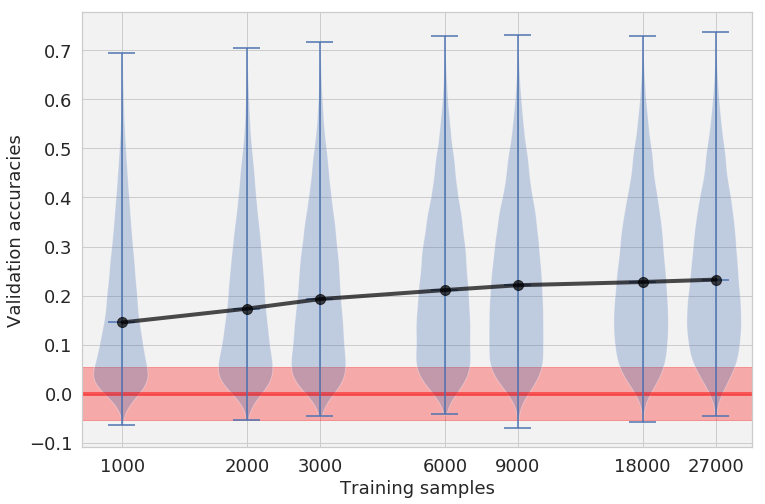

In [130]:
fig=plt.figure(figsize=(12,8))
plt.hlines(y=[0], xmin=800, xmax=33000, color='r', lw=4, alpha=.5)
plt.fill_between([800,33000], [-cc_th, -cc_th], [cc_th, cc_th], color='r', alpha=0.3)
plt.violinplot(result_cc, positions=trn_sizes, widths=trn_sizes*.3, showmedians=True)
plt.plot(trn_sizes, median_cc, marker='o', ms=10, color='k', lw=4, alpha=.7)
plt.xscale('log')
plt.xlim([800, 33000])
plt.gca().set_xticks(trn_sizes)
plt.gca().set_xticklabels(trn_sizes)
plt.xlabel('Training samples')
plt.ylabel('Validation accuracies')

In [131]:
filename = output_dir + "validation_scaling_%s%s" % (timestamp, saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close() 